참고 : https://devlee247.com/papers/2022-06-20-googlenet/

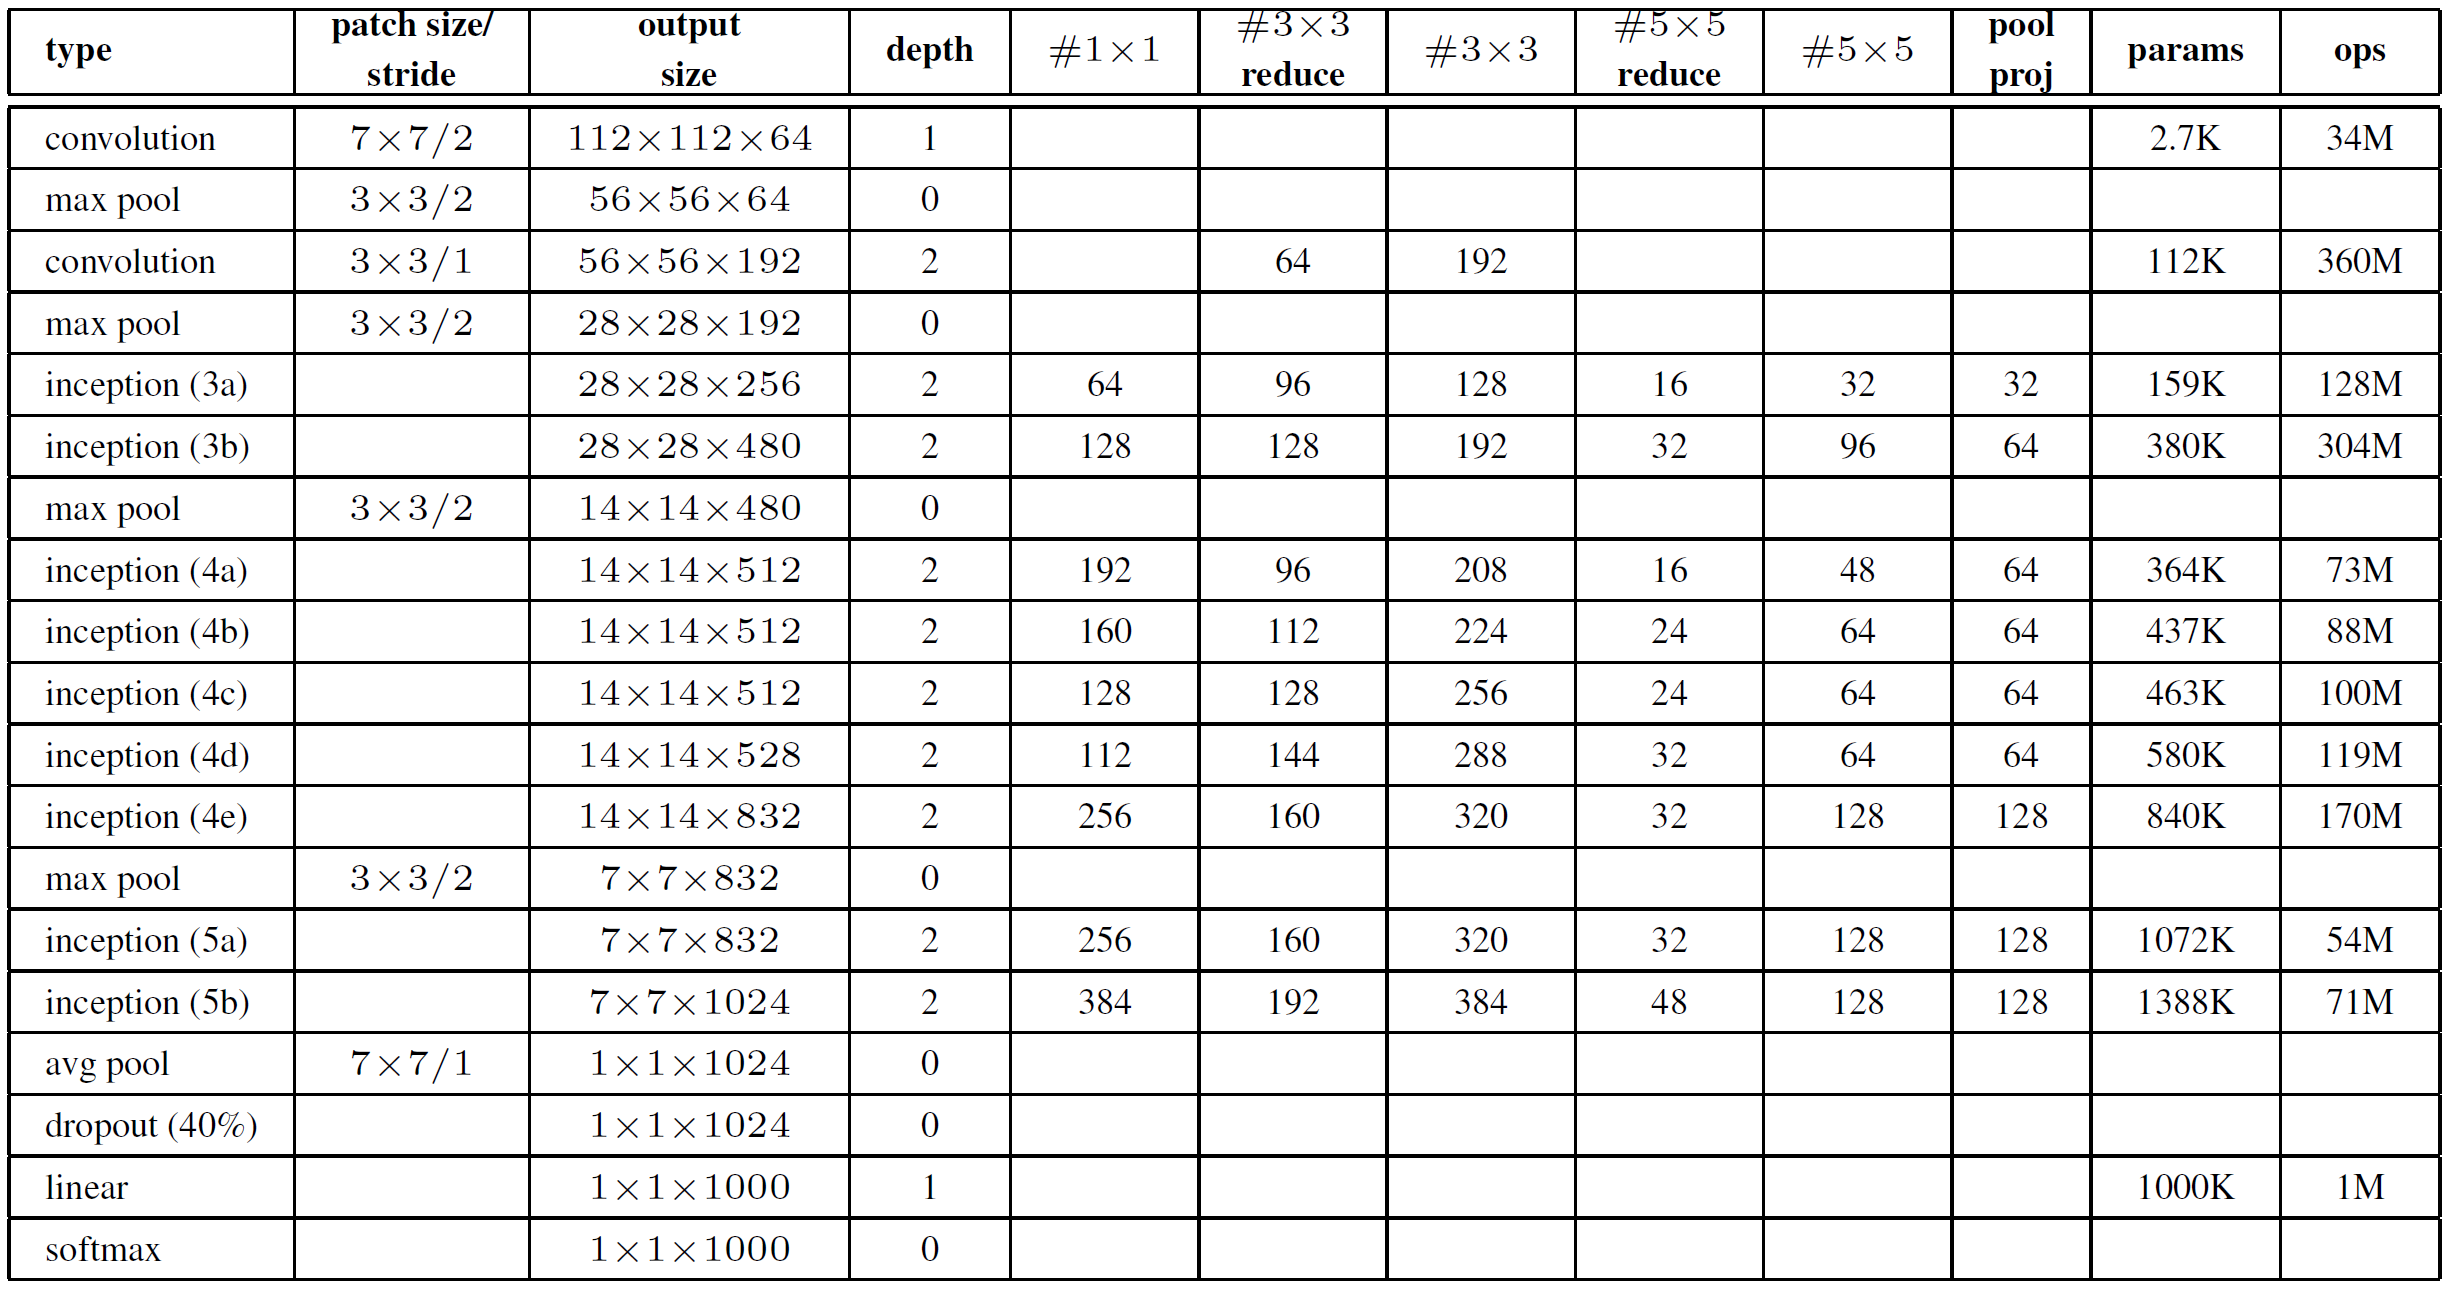

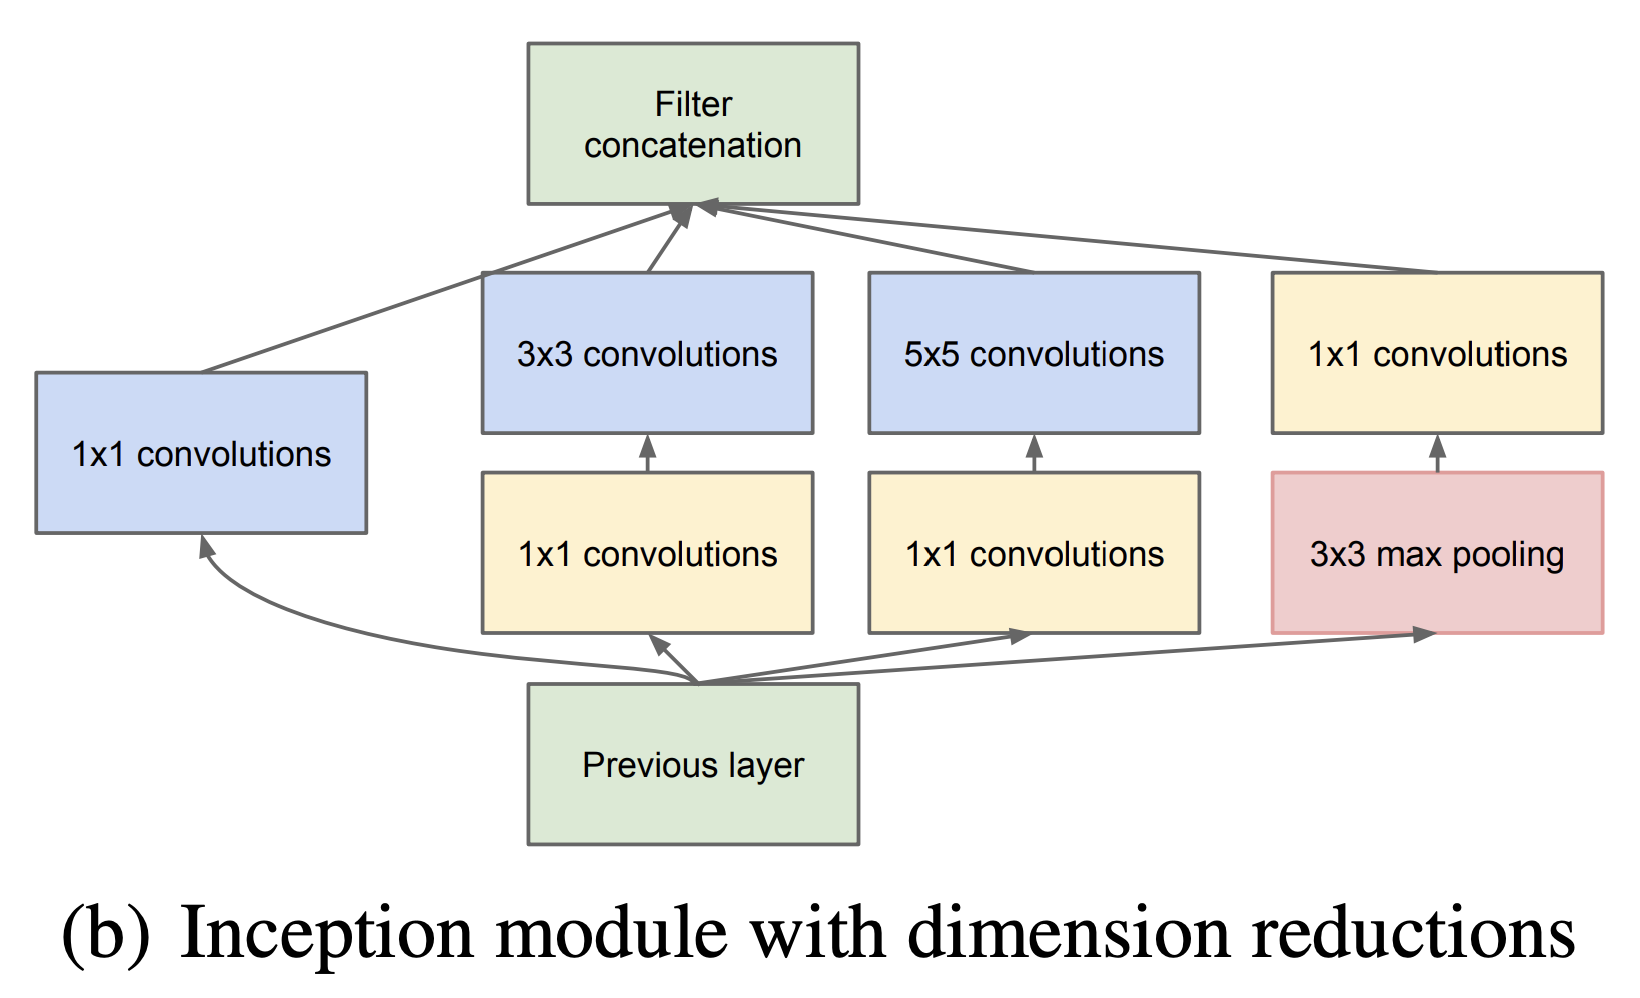

특징
1. 에버리지풀링
2. 인셉션
3. 1바이1 리덕션
4. Auxilary head

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# Conv2d 정의
class BaseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BaseConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.ReLU(inplace = true)

    def forward(self, x):
        return self.ReLU(self.conv(x))

In [ ]:
# inception 모듈 정의
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_redu, ch3x3, ch5x5_redu, ch5x5, pool):
        super(InceptionModule, self).__init__()
        self.conv1x1 = nn.BaseConv2d(in_channels, ch1x1, kerner_size=1)
        self.conv3x3 = nn.Sequential(
            BaseConv2d(in_channels, ch3x3_redu, kernel_size=1),
            BaseConv2d(ch3x3_redu, ch3x3, kernel_size=3, padding=1)
        )
        self.conv5x5 = nn.Sequential(
            BaseConv2d(in_channels, ch5x5_redu, kernel_size=1),
            BaseConv2d(ch5x5_redu, ch5x5, kenel_size=5, padding=2)
        )
        self.pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            BaseConv2d(in_channels, pool, kernel_size=1)
        )
        
    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = slef.conv3x3(x)
        x3 = self.conv5x5(x)
        x4 = self.pool(x)

        return torch.cat([x1, x2, x3, x4), 1) # 콘캣으로 하나로 합침.

In [ ]:
# 보조 분류기 구현
class AuxModule(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AuxModule, self).__init__()

        self.avgpool = nn.AdaptiveAvgPool2d((4,4)) #4x4가 되도록 함.
        self.conv1 = BaseConv2d(in_channels, 128, kernel_size=1)
        self.fc = nn.Sequential(
            nn.Linear(4*4*128, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.7),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
# 최종 구글넷
class GoogLeNet(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(GoogLeNet, self).__init__()

        self.training = True
        
        self.conv1 = nn.Sequential(
            BaseConv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(2)
        )

        self.conv2 = nn.Sequential(
            BaseConv2d(64, 64, kernel_size=1),
            BaseConv2d(64, 192, kernel_size=3, padding=1),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.inception_3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.aux1 = AuxModule(512, num_classes)

        self.inception_4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.aux2 = AuxModule(528, num_classes)

        self.inception_4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.fc = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool_3(x)

        x = self.inception_4a(x)
        if self.training:
            out1 = self.aux1(x)

        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        if self.training:
            out2 = self.aux2(x)

        x = self.inception_4e(x)
        x = self.maxpool_4(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)                
        if self.training:
            return [x, out1, out2]
        else:
            return x
    
    def set_train(self):
        self.training = True
        
    def set_eval(self):
        self.training = False